In [1]:
 from tqdm import tqdm
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, truncexpon, truncnorm, nbinom
import pandas as pd
import torch
from torch import nn
from torch import distributions

In [2]:
np.random.seed(seed=101)
torch.manual_seed(101)
torch.use_deterministic_algorithms(True)
dtype = torch.float64
device = torch.device("cpu")


In [3]:
data = pd.read_csv('../../data/covid19model.csv')
data.head(3)

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674


In [4]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)
num_observations = len(observed_daily_hospit)
model = [observed_daily_hospit,pi,serial_interval,num_observations]

In [16]:
def trunc_exponential(scale, upper):
    sample = torch.distributions.exponential.Exponential(1/scale).rsample()
    sample = sample/torch.tensor(1-torch.exp(-upper/scale))
    return sample
# torch.distributions.exponential.Exponential(1/scale).sample()/torch.tensor(1-torch.exp(-upper/scale))

In [27]:
def trunc_normal(mu, sigma, under, upper):
    distribution = torch.distributions.normal.Normal(loc=mu, scale=sigma, validate_args=None)
    normal_sample = distribution.rsample()
    cumulative = distribution.cdf(torch.tensor(upper)) - distribution.cdf(torch.tensor(under))
    return normal_sample/cumulative


In [17]:
tau= torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = trunc_exponential(tau, 1000) # number of initial newly_infected (seed)

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
phi = torch.tensor(truncnorm.rvs((0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step

<ipython-input-16-fa868acd251b>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = sample/torch.tensor(1-torch.exp(-upper/scale))


In [18]:
def forward_pass():

    # log li elihood wrt. our prior ("regularisation")
    # ll stands for log-likelihood
    ll = torch.tensor(0.0)
    # Initialize time series variables
    newly_infected = torch.zeros(num_observations)  # number of newly infected
    effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
    expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
    cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
    eta_t = torch.zeros(num_observations)  # transformed reproduction number
    epsilon_t = torch.zeros(num_observations)  # random walk
    St = torch.zeros(num_observations)  # fraction of susceptible population



    '''
    ll += torch.tensor(expon.logpdf(tau_t, 1 / 0.03))
    ll += torch.tensor(truncexpon.logpdf(y,b=(1000 - 0) / tau_t, loc=0, scale=tau_t))
    ll += torch.tensor(truncnorm.logpdf(phi,(0 - 25) / 10, (np.inf - 25) / 10, loc=25, scale=10))
    ll += torch.tensor(truncnorm.logpdf(R0,(2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8))
    ll += torch.tensor(truncnorm.logpdf(alpha,(0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100))
    ll += torch.tensor(truncnorm.logpdf(sigma,(0 - 0.1) / 0.3, (0.5 - 0.1) / 0.3, loc=0.1, scale=0.3))
    '''

    # seed initial infection / impute first num_impute days
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, torch.tensor(0)) / population for x in cumulative_infected[0:num_impute].clone()])

    # calculate Rt: the basic reproduction number
    # basic reproduction number as a latent random walk
    beta_0 = torch.log(R0)
    #epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
    #for t in range(1, num_observations):
    #    epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()
    #eta_t = beta_0 + epsilon_t  # + RNN[X_t, t]  # .clone() necessary?
    eta_t[0] = beta_0
    epsilon_t[0] = torch.distributions.Normal(cero, sigma).rsample()
    for t in range(1, num_observations):
        epsilon_t[t] = torch.distributions.Normal(epsilon_t[t - 1].clone(), sigma).rsample()
        dist_epsilon_t = torch.distributions.Normal(epsilon_t[t - 1], sigma)
        ll += dist_epsilon_t.log_prob(epsilon_t[t - 1]).item() #epsilon_t.log_prob(epsilon_t[t - 1])
        #eta_t[t] = epsilon_t[t-1]
    eta_t[1:num_observations] = beta_0 + epsilon_t[0:num_observations-1].clone()
    Rt = torch.exp(eta_t)

    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        for i in range(0, t - 1):
          effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()
        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()

    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        for i in range(0, t):
            expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
    expected_daily_hospit = alpha * expected_daily_hospit

    # compare observed hospitalizations to model results
    # likelihood of the data wrt. to the model
    dist = 0
    for i in range(1, num_observations):

        p = 1/(1+ expected_daily_hospit[i]/phi)
        dist = torch.distributions.negative_binomial.NegativeBinomial(phi, p-torch.tensor(2.225e-5))
        ll += dist.log_prob(observed_daily_hospit[i])


    return expected_daily_hospit, ll

Time Step: 0, Loss: 108640.28125, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 63733.2578125
k: 0|| R0:3.398224922312992, grad: -141.9016743082816, alpha: 0.01000078612167788 grad: -80467.953125, sigma: 0.45760547758958436 grad -2567.9085527409416 

Time Step: 1, Loss: 108436.265625, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 57457.75390625
k: 1|| R0:3.3982249224548937, grad: 233.38834161942964, alpha: 0.010000866589631006 grad: -75834.65625, sigma: 0.4576054801574929 grad 3757.9487661957405 

Time Step: 2, Loss: 87143.4140625, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 91502.34375
k: 2|| R0:3.3982249222215053, grad: -7275.325198335555, alpha: 0.010000942424287257 grad: -541768.25, sigma: 0.45760547639954413 grad 37668.84838029613 

Time Step: 3, Loss: 107532.9921875, Observed_daily_hospit: 13199.0, Expected_daily_hospit: 51959.328125
k: 3|| R0:3.3982249294968305, grad: 475.4932116813825, alpha: 0.010001484192537257 grad: -66364.515625, sigma: 0.457605

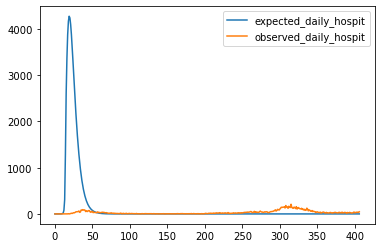

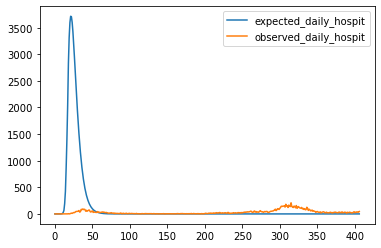

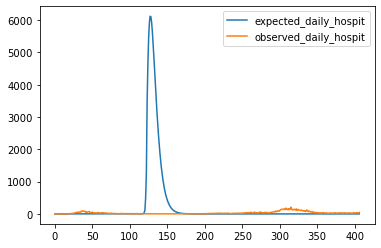

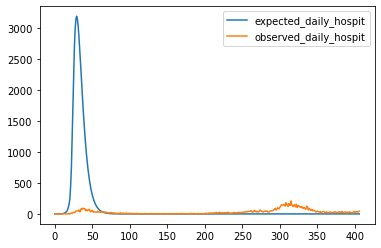

KeyboardInterrupt: 

In [19]:
learning_rate = 1e-12

for k in range (400):
# forward pass - calculate expected_daily_hospit
    loss = 0.
    expected_daily_hospit, ll = forward_pass()

    loss = -ll

    loss.backward()

    print(f'Time Step: {k}, Loss: {loss}, Observed_daily_hospit: {torch.sum(observed_daily_hospit)}, Expected_daily_hospit: {torch.sum(expected_daily_hospit)}')
    print(f'k: {k}|| R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, sigma: {sigma} grad {sigma.grad} \n' )

    plt.plot(expected_daily_hospit.detach().numpy(), label='expected_daily_hospit')
    plt.plot(observed_daily_hospit.detach().numpy(), label='observed_daily_hospit')
    plt.legend()
    plt.show()

    with torch.no_grad():
        tau -= learning_rate * tau.grad
        phi -= learning_rate * phi.grad
        R0 -= learning_rate * R0.grad
        alpha -= learning_rate * alpha.grad
        sigma -= learning_rate * sigma.grad

        tau.grad = None
        phi.grad = None
        R0.grad = None
        alpha.grad = None
        sigma.grad = None

